In [5]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import pickle as pkl
import shutil
def read_spec(file):
    data=pd.read_csv(file,header=None)
    data=data.to_numpy()
    return data

def interpolate_spec(spectrum,length=100,seed=0):
    '''
    ## Interpolate the spectrum to a new length
        - Firstly the energy range is interpolated to the desired length, typically 100 for XANES and 500 for EXAFS
        - Then the intensity is interpolated using the linear interpolation and newly interpolated energy range

    ### Args:
        - spectrum: numpy array, shape=(n,2), the first column is the energy and the second column is the intensity
        - length: int, the length of the new spectrum
        - seed: int, random seed for reproducibility

    ### Returns:
        - new_spectrum: numpy array, shape=(length,2), the first column is the energy and the second column is the intensity
    '''
    np.random.seed(seed)
    X_val = spectrum[:, 0]
    Y_val = spectrum[:, 1]
    sorted_indices = np.argsort(X_val)
    X_val = X_val[sorted_indices]
    Y_val = Y_val[sorted_indices]
    if len(X_val) == length:
        return np.column_stack((X_val, Y_val))
    else:
        x_tmp = np.interp(np.linspace(0, len(X_val)-1, length*4), np.arange(len(X_val)), X_val)
        x_tmp = np.random.choice(x_tmp,length,replace=False) # To avoid the interpolation error caused by the length-len(X_val)>len(new_X)
        if len(X_val)<length:
            new_X=np.setdiff1d(np.unique(np.concatenate((X_val,x_tmp))),X_val)
            inter_choice=np.random.choice(new_X,length-len(X_val),replace=False)
            new_X=np.concatenate((X_val,inter_choice))
            new_sort=np.argsort(new_X)
            new_X=new_X[new_sort]
        else:
            new_X=x_tmp
        interpolator = interp1d(X_val, Y_val, kind='linear', fill_value='extrapolate')
        new_Y = interpolator(new_X)
        new_spectrum = np.column_stack((new_X, new_Y))
        return new_spectrum

def interpolate_error(spectrum,new_spec):
    _x=spectrum[:,0]
    _y=spectrum[:,1]
    new_X=new_spec[:,0]
    new_Y=new_spec[:,1]
    interpolator = interp1d(new_X, new_Y, kind='linear', fill_value='extrapolate')
    Y_interpolated_at_original_X = interpolator(_x)
    mse = ((_y-Y_interpolated_at_original_X)**2).mean()
    return mse,Y_interpolated_at_original_X

spectrum=read_spec('../XAS_Extraction/labeled/2IDCNVUY/XANES/fig4/fig4a.csv')

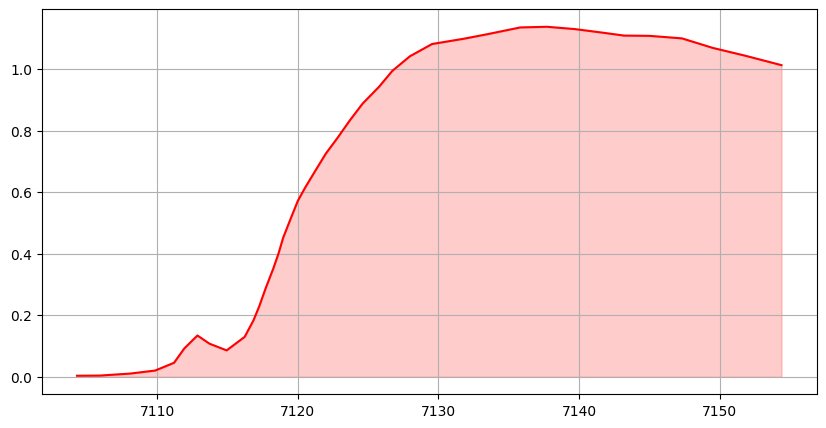

In [46]:
plt.figure(figsize=(10, 5))
# sns.set_style("whitegrid")
sns.lineplot(x=spectrum[:,0],y=spectrum[:,1],color='red')
plt.fill_between(spectrum[:,0], spectrum[:,1], color='red', alpha=0.2)
# sns.scatterplot(x=spectrum[:,0],y=spectrum[:,1],color='black')
plt.grid()
plt.savefig('spectrum_plot.png', transparent=True,dpi=200)

Interpolation Error:  0.0


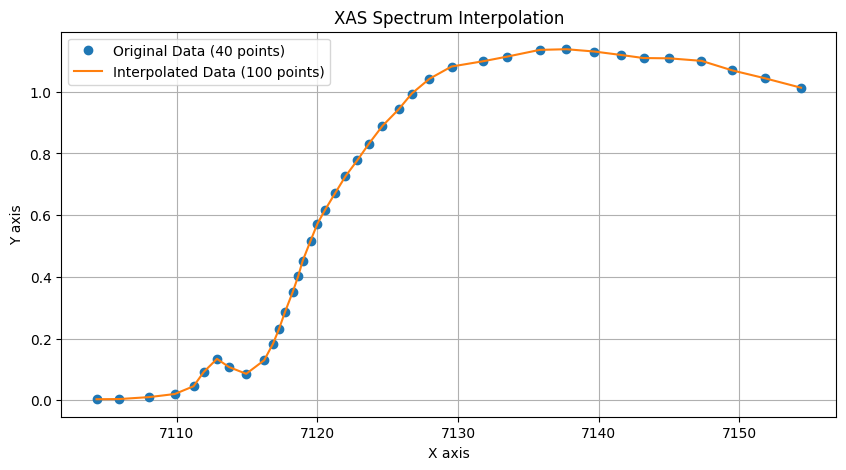

In [7]:
new_spectrum = interpolate_spec(spectrum, length=100)
print('Interpolation Error: ',interpolate_error(spectrum,new_spectrum)[0])
X,Y=spectrum[:,0],spectrum[:,1]
new_X,new_Y=new_spectrum[:,0],new_spectrum[:,1]
# Plotting for visualization
plt.figure(figsize=(10, 5))
plt.plot(X, Y, 'o', label=f'Original Data ({len(X)} points)')
plt.plot(new_X, new_Y, '-', label=f'Interpolated Data ({len(new_X)} points)')
plt.legend()
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.grid()
plt.title('XAS Spectrum Interpolation')
plt.show()

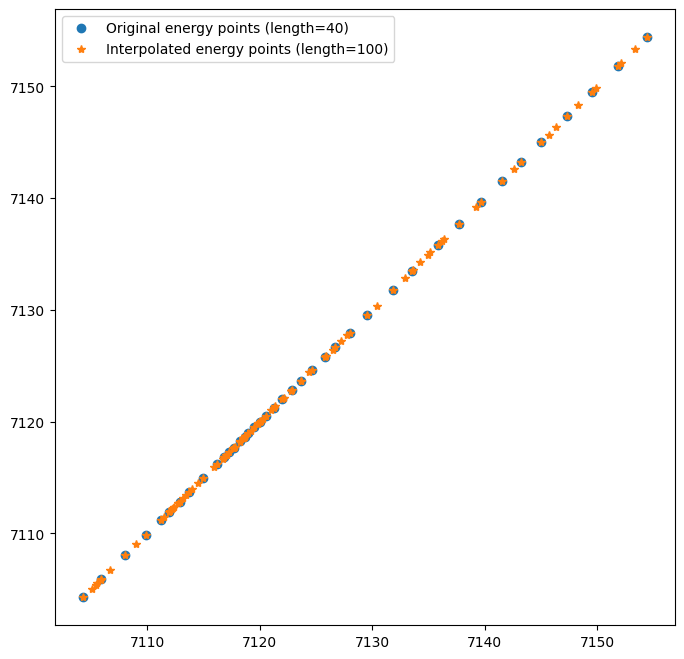

In [8]:
plt.figure(figsize=(8, 8))
plt.plot(X, X,'o', label=f'Original energy points (length={len(X)})')
plt.plot(new_X, new_X, '*', label=f'Interpolated energy points (length={len(new_X)})')
plt.legend()
# plt.grid()